In [1]:
#!/usr/bin/env python

# Python Standard Library Modules
import os
import pathlib
import pickle
import random
import sys
import warnings

# External Libraries
import gluonts
from gluonts.dataset import common
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.model import deepar
from gluonts.mx.trainer import Trainer
from hyperopt import fmin, hp, tpe, STATUS_OK, STATUS_FAIL, Trials
from hyperopt.pyll import scope
import matplotlib
import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings("ignore")
mx.random.seed(0)
np.random.seed(0)

prediction_length = 30

In [2]:
mx.__version__

'1.5.1'

### General Stocks

In [3]:
# gluon_list = []
# def covert_yahoo_series_dir(path: str, prediction_length: int, gluon_list=None) -> list:
#     """Clean and load all biotech histories in the Yahoo biotech folder

#     Params:
#         path: folder full of historical crypto coins timeseries data
#         prediction_length: length on which to predict
#     Returns:
#         List of Gluon-compatible dicts from the coin data
#     """
#     if gluon_list is not None:
# #         print("NOT NONE")
#         gluon_list = gluon_list
#     else:
#         gluon_list = []
#     for file in os.listdir(path):
#         stock_gluon_dict = dict()
#         file_path = path + file
#         stock = pd.read_csv(file_path)
#         stock["Date"] = pd.to_datetime(stock["Date"])
#         stock.set_index("Date", inplace=True)
#         total_na_vals = stock.isna().sum()[0]
#         stock = stock.asfreq("B")
#         total_na_vals = stock.isna().sum()[0]
#         if (total_na_vals / len(stock)) > 0.25:
#             continue
#         # Get values for ListDatasets
#         stock_closes = stock["Close"]
#         stock_closes.index = pd.DatetimeIndex(stock_closes.index)
#         stock_closes = stock_closes.asfreq("B")
#         start = stock_closes.index[0]
        
#         stock_gluon_dict["test"] = {
#             "start": start,
#             "target": stock_closes,
#             "name": file,
#         }

#         stock_gluon_dict["train"] = {
#             "start": start,
#             "target": stock_closes[:-prediction_length],
#             "name": file,
#         }

#         gluon_list.append(stock_gluon_dict)

#     return gluon_list


# gluon_list = covert_yahoo_series_dir("../data/historical_yahoo_general_stocks/", prediction_length=30)

In [4]:
# import pickle

# filehandler = open("gluon_list.pickle", "wb")
# pickle.dump(gluon_list, filehandler)
# filehandler.close()


In [5]:
file = open("gluon_list.pickle",'rb')
gluon_list = pickle.load(file)
file.close()


In [6]:
warnings.filterwarnings("always")

import mxnet as mx
mx.random.seed(0)
np.random.seed(0)


test_data = common.ListDataset(
    [
    ],
    freq="B",
)

train_data = common.ListDataset(
    [
    ],
    freq="B",
)

for stock_gluon_dict in gluon_list:
    test_data.list_data.append(stock_gluon_dict['test'])
    train_data.list_data.append(stock_gluon_dict['train'])

In [8]:
# Best Hyperopt from like 8 trials

{'cell_type': 'lstm', 'context_length': 74, 'dropout_rate': 0.195, 'epochs': 20, 'learning_rate': 0.029400000000000003, 'num_cells': 108, 'num_layers': 1}


{'cell_type': 'lstm',
 'context_length': 74,
 'dropout_rate': 0.195,
 'epochs': 20,
 'learning_rate': 0.029400000000000003,
 'num_cells': 108,
 'num_layers': 1}

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,
/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,
/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,
100%|██████████| 50/50 [00:06<00:00,  8.19it/s, epoch=20/20, avg_epoch_loss=0.969]


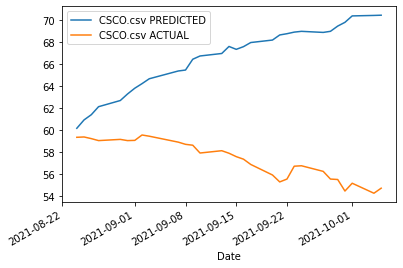

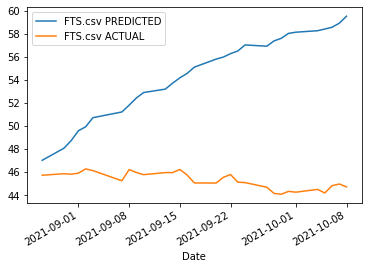

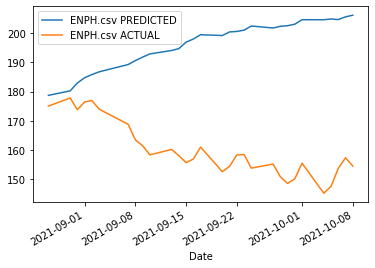

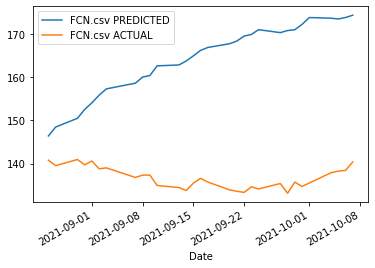

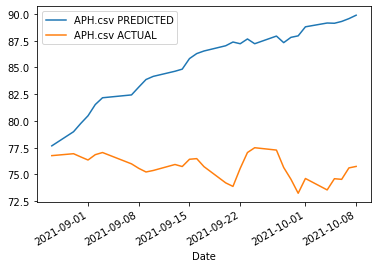

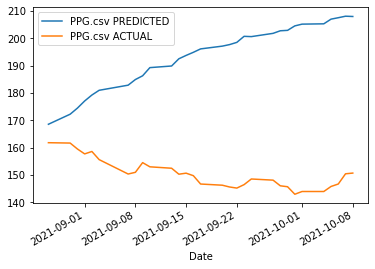

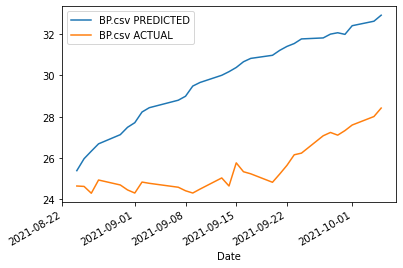

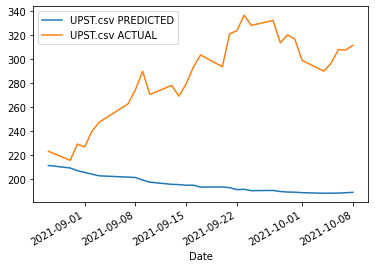

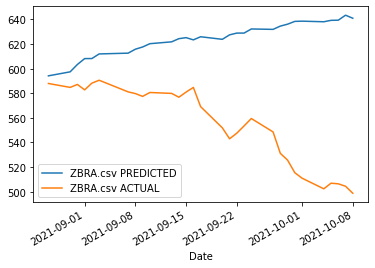

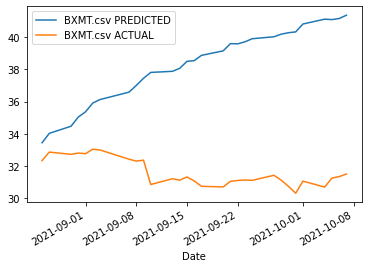

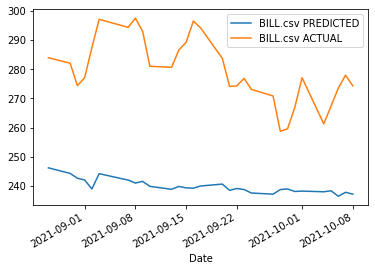

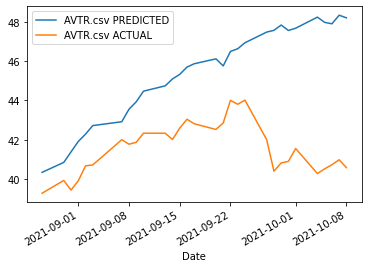

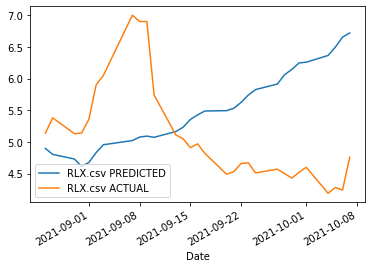

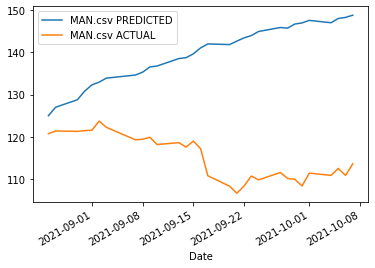

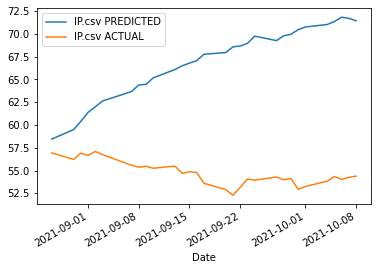

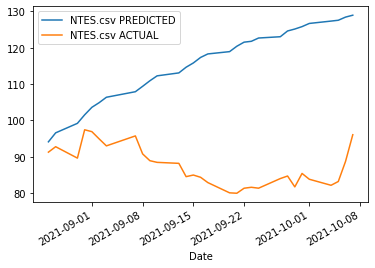

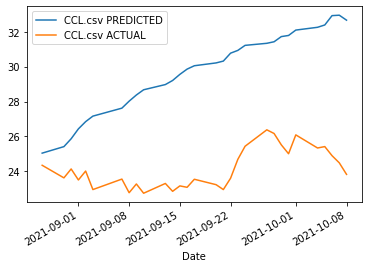

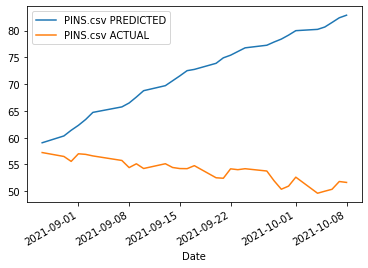

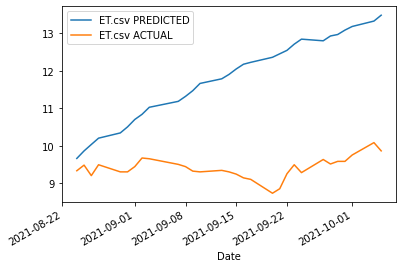

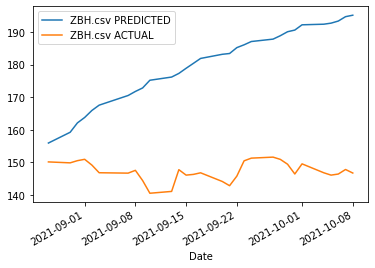

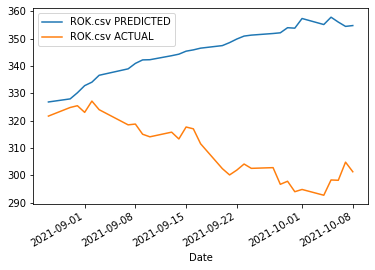

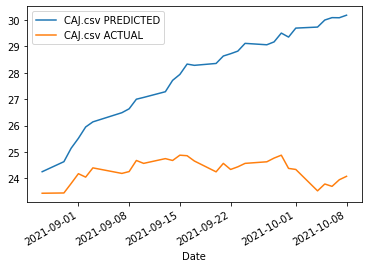

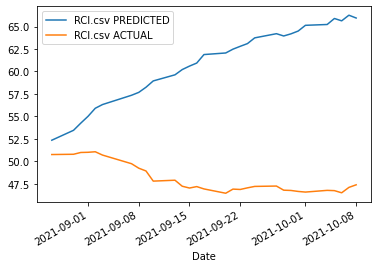

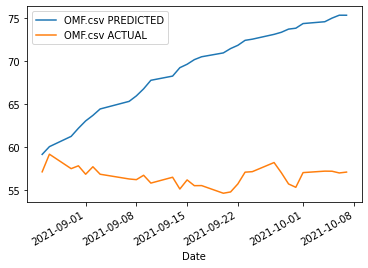

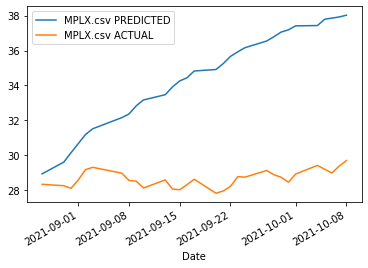

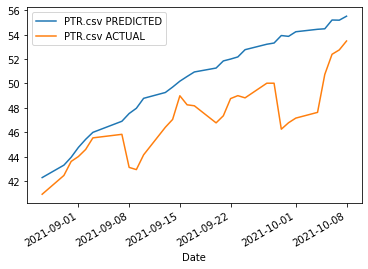

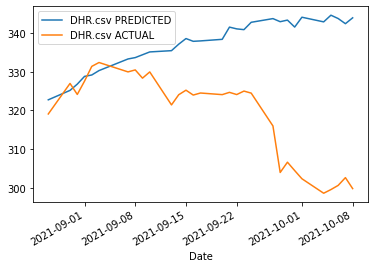

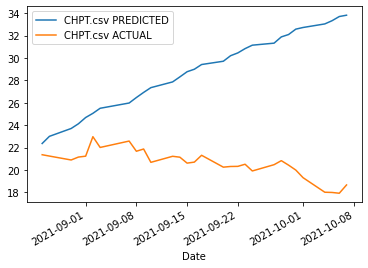

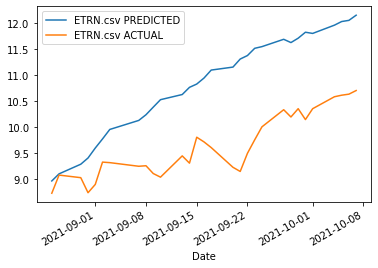

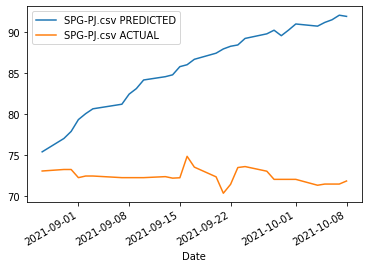

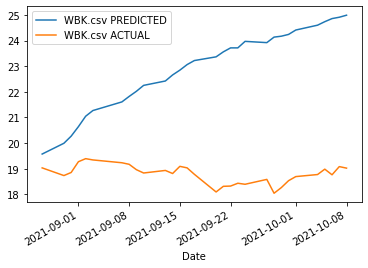

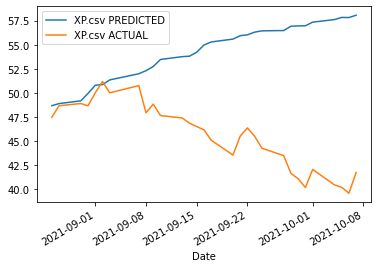

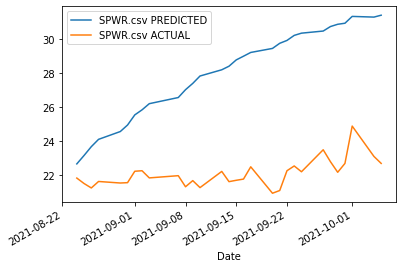

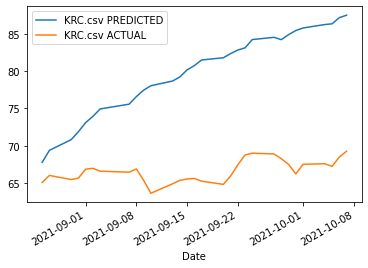

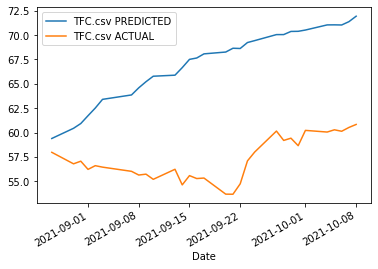

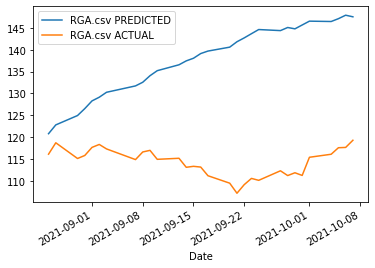

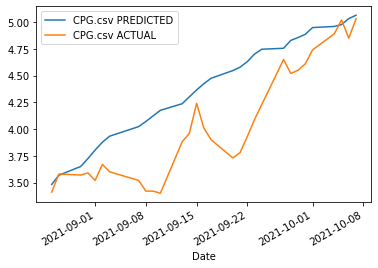

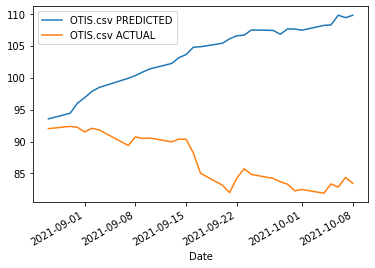

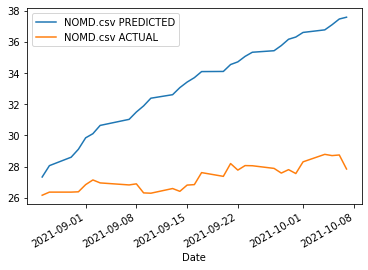

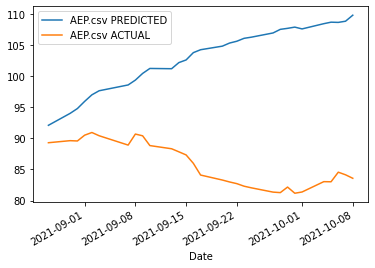

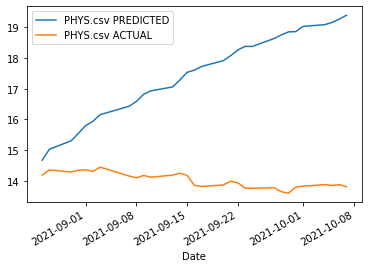

average global_loss is 8.474885992401031


In [4]:
random.seed(0)
mx.random.seed(0)
np.random.seed(0)
global_loss = 0
trainer = Trainer(epochs=20, learning_rate=0.029400000000000003)
estimator = deepar.DeepAREstimator(
        freq="B",
        num_cells=108,
        num_layers=1,
        context_length=74,
        prediction_length=prediction_length, 
        trainer=trainer,
        dropout_rate=0.195,
    )

predictor = estimator.train(
    training_data=train_data,
)


predictions = predictor.predict(train_data.list_data)


for index, value in enumerate(range(len(gluon_list))):
    prediction = next(predictions)
    name = test_data.list_data[index]['name']
    full_actual = test_data.list_data[index]['target']
    full_actual.dropna(inplace=True)
    actual = full_actual[-30:]
    preds = pd.Series(prediction.mean)
    preds.index = actual.index
#     mse = mean_squared_error(actual, preds)
    
#    PLOT ALL PREDICTIONS
    if index % 25 == 0:
        plt.figure()
        preds.plot(legend=True, label=f"{name} PREDICTED")
        actual.plot(legend=True, label=f"{name} ACTUAL")
        plt.show()

    
    scaler = MinMaxScaler()
    scaled_actual = np.array(actual)
    scaler.fit([scaled_actual])
    scaled_actual = scaler.fit_transform(np.array(scaled_actual[:, np.newaxis]))
    scaled_preds = scaler.transform([preds])
    scaled_preds = scaled_preds.reshape(-1, 1)
    mse = mean_squared_error(scaled_actual, scaled_preds)
#     print(f"mse: {mse}")
    global_loss += mse
    
print(f"average global_loss is {global_loss / len(gluon_list)}")

In [201]:
70 cells 5 layers 30 epochs 512 batch size 60 context length:    2.4904398118604307
70 cells 5 layers 30 epochs 512 batch size:                      0.9237185129645219
150 cells 3 layers 10 epochs:                                    5.2231017979000045
batch_size 512 10 epochs:                                        1.6157811417753714
batch_size 256 10 epochs:                                        1.2300746956301858
batch_size 128 10 epochs:                                        0.8353096293010092
batch_size 64 10 epochs:                                         1.3203255444205146

 


base all 60 epochs:                                              1.68
base all 50 epochs:                                              0.28
base all 40 epochs:                                              0.25
base all 30 epochs:                                              0.39
base all 20 epochs:                                              0.34
base all 10 epochs:                                              ~1.06


average global_loss is 1.2ish               # 18
average global_loss is 0.8193485594635367   # 36
average global_loss is 1.0578433766058088   # 54
average global_loss is 1.0184960608247695   # 69
average global_loss is 1.0639288802030842   # 86
average global_loss is 0.9494059324316426   # 204
average global_loss is 0.8880175967582968   # 241
average global_loss is 1.9637798520177      # 276 different exchange
average global_loss is 0.9105032333595303   # 240 attempted restore
average global_loss is 0.9554277347125465   # 258 w/ big tech movers
average global_loss is 0.335191223822778   # 258 w/ big tech movers 10 epochs
average global_loss is 0.6163794000905585   # 258 w/ big tech movers 50 epochs
average global_loss is 0.4051840267830506   # 258 wo/ big tech movers 10 epochs

SyntaxError: invalid syntax (<ipython-input-201-02862b3e764e>, line 1)

In [ ]:
random.seed(0)
mx.random.seed(0)
np.random.seed(0)

search_space = {
    'epochs': 30,
    'num_layers': scope.int(hp.quniform('num_layers', 1, 3, q=1)),
    'num_cells': scope.int(hp.quniform('num_cells', 30, 120, q=1)),
    'cell_type': hp.choice('cell_type', ['lstm', 'gru']),
    'learning_rate': hp.quniform('learning_rate', 5e-5, 1e-1, 0.00005),
    'context_length': scope.int(hp.quniform('context_length', 30, 150, q=1)),
    'dropout_rate': hp.quniform('dropout_rate', 0, 0.2, 0.005),
}

def global_objective(params):
    print(f"TRYING: {params}")
    try:
        deepar_params = {k: v for k,v in params.items() if k not in ('epochs', 'learning_rate')}
        epochs = params['epochs']
        learning_rate = params['learning_rate']
        cell_type = params['cell_type']
        trainer = Trainer(
                          epochs=epochs, 
                          num_batches_per_epoch=50,
                          learning_rate=learning_rate,
                          patience=2,
#                           clip_gradient=1.5,
                          )
        estimator = deepar.DeepAREstimator(
            freq="B", 
            prediction_length=prediction_length, 
            trainer=trainer,
            **deepar_params,
        )
        predictor = estimator.train(training_data=train_data)
        predictions = predictor.predict(train_data.list_data)

        forecast_it, ts_it = make_evaluation_predictions(
            dataset=test_data,
            predictor=predictor,

        )

        forecasts = list(forecast_it)
        tss = list(ts_it)
        evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])

        agg_metrics, item_metrics = evaluator(
            iter(tss), 
            iter(forecasts), 
            num_series=len(test_data.list_data)
        )

        smape = agg_metrics['sMAPE']

        return {'loss': smape, 'status': STATUS_OK}
    
    except BaseException as e:
        print(f"ERROR: {e}")
        return {'status': STATUS_FAIL}

trials = Trials()
best = fmin(
    global_objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=60,
    trials=trials,
)

TRYING: {'cell_type': 'lstm', 'context_length': 128, 'dropout_rate': 0.03, 'epochs': 30, 'learning_rate': 0.050100000000000006, 'num_cells': 102, 'num_layers': 2}
  0%|          | 0/60 [00:00<?, ?trial/s, best loss=?]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

 66%|######6   | 33/50 [00:10<00:05,  3.21it/s, epoch=1/30, avg_epoch_loss=6.74]

  0%|          | 0/50 [00:00<?, ?it/s]

 68%|######8   | 34/50 [00:10<00:04,  3.35it/s, epoch=2/30, avg_epoch_loss=6.11]

  0%|          | 0/50 [00:00<?, ?it/s]

 58%|#####8    | 29/50 [00:10<00:07,  2.83it/s, epoch=3/30, avg_epoch_loss=4.07]

  0%|          | 0


  0%|          | 0/50 [00:00<?, ?it/s]

 42%|####2     | 21/50 [00:10<00:14,  2.01it/s, epoch=28/30, avg_epoch_loss=1.65]

 84%|########4 | 42/50 [00:20<00:03,  2.01it/s, epoch=28/30, avg_epoch_loss=1.66]

  0%|          | 0/50 [00:00<?, ?it/s]

 42%|####2     | 21/50 [00:10<00:14,  2.06it/s, epoch=29/30, avg_epoch_loss=1.64]

 86%|########6 | 43/50 [00:20<00:03,  2.09it/s, epoch=29/30, avg_epoch_loss=1.66]

  0%|          | 0/50 [00:00<?, ?it/s]

 42%|####2     | 21/50 [00:10<00:14,  2.06it/s, epoch=30/30, avg_epoch_loss=1.78]

 84%|########4 | 42/50 [00:20<00:03,  2.08it/s, epoch=30/30, avg_epoch_loss=1.71]

Running evaluation:   0%|          | 0/1017 [00:00<?, ?it/s]

Running evaluation: 100%|##########| 1017/1017 [00:00<00:00, 7015.25it/s]


TRYING: {'cell_type': 'gru', 'context_length': 143, 'dropout_rate': 0.07, 'epochs': 30, 'learning_rate': 0.0663, 'num_cells': 88, 'num_layers': 2}
  2%|▏         | 1/60 [14:39<14:24:29, 879.14s/trial, best loss: 0.0914485108558881]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

 62%|######2   | 31/50 [00:10<00:06,  3.10it/s, epoch=1/30, avg_epoch_loss=6.31]

  0%|          | 0/50 [00:00<?, ?it/s]

 64%|######4   | 32/50 [00:10<00:05,  3.20it/s, epoch=2/30, avg_epoch_loss=5.81]

  0%|          | 0/50 [00:00<?, ?it/s]

 68%|######8   | 34/50 [00:10<00:04,  3.31it/s, epoch=3/30, avg_epoch_loss=7.16]

  0%|          | 0

TRYING: {'cell_type': 'gru', 'context_length': 104, 'dropout_rate': 0.1, 'epochs': 30, 'learning_rate': 0.0455, 'num_cells': 63, 'num_layers': 2}
  3%|▎         | 2/60 [25:13<11:50:50, 735.35s/trial, best loss: 0.0831488988898802]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 92%|#########2| 46/50 [00:10<00:00,  4.55it/s, epoch=5/30, avg_epoch_loss=2.15]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 

TRYING: {'cell_type': 'gru', 'context_length': 105, 'dropout_rate': 0.125, 'epochs': 30, 'learning_rate': 0.07605, 'num_cells': 97, 'num_layers': 2}
  5%|▌         | 3/60 [32:36<9:31:40, 601.77s/trial, best loss: 0.0831488988898802]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

 68%|######8   | 34/50 [00:10<00:04,  3.36it/s, epoch=1/30, avg_epoch_loss=6.67]

  0%|          | 0/50 [00:00<?, ?it/s]

 80%|########  | 40/50 [00:10<00:02,  3.93it/s, epoch=2/30, avg_epoch_loss=6.07]

  0%|          | 0/50 [00:00<?, ?it/s]

 56%|#####6    | 28/50 [00:10<00:08,  2.73it/s, epoch=3/30, avg_epoch_loss=7.02]

  0%|          | 0

Early stopping based on learning rate scheduler callback (min_lr was reached).     
  5%|▌         | 3/60 [39:21<9:31:40, 601.77s/trial, best loss: 0.0831488988898802]

Running evaluation:   0%|          | 0/1017 [00:00<?, ?it/s]

Running evaluation: 100%|##########| 1017/1017 [00:00<00:00, 8088.62it/s]


TRYING: {'cell_type': 'lstm', 'context_length': 46, 'dropout_rate': 0.13, 'epochs': 30, 'learning_rate': 0.06565, 'num_cells': 80, 'num_layers': 3}
  7%|▋         | 4/60 [42:04<9:09:06, 588.33s/trial, best loss: 0.0831488988898802]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

 70%|#######   | 35/50 [00:10<00:04,  3.44it/s, epoch=1/30, avg_epoch_loss=6.17]

  0%|          | 0/50 [00:00<?, ?it/s]

 54%|#####4    | 27/50 [00:10<00:08,  2.68it/s, epoch=2/30, avg_epoch_loss=6.92]

  0%|          | 0/50 [00:00<?, ?it/s]

 60%|######    | 30/50 [00:10<00:06,  2.91it/s, epoch=3/30, avg_epoch_loss=6.26]

  0%|          | 0

Early stopping based on learning rate scheduler callback (min_lr was reached).     
  7%|▋         | 4/60 [49:56<9:09:06, 588.33s/trial, best loss: 0.0831488988898802]

Running evaluation:   0%|          | 0/1017 [00:00<?, ?it/s]

Running evaluation: 100%|##########| 1017/1017 [00:00<00:00, 8364.25it/s]


TRYING: {'cell_type': 'gru', 'context_length': 37, 'dropout_rate': 0.05, 'epochs': 30, 'learning_rate': 0.0263, 'num_cells': 73, 'num_layers': 3}
  8%|▊         | 5/60 [52:57<9:20:39, 611.63s/trial, best loss: 0.0831488988898802]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [0

TRYING: {'cell_type': 'gru', 'context_length': 64, 'dropout_rate': 0.12, 'epochs': 30, 'learning_rate': 0.0762, 'num_cells': 107, 'num_layers': 3}
 10%|█         | 6/60 [59:04<7:55:39, 528.50s/trial, best loss: 0.06702432258815734]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

 72%|#######2  | 36/50 [00:10<00:03,  3.58it/s, epoch=1/30, avg_epoch_loss=8.21]

  0%|          | 0/50 [00:00<?, ?it/s]

 74%|#######4  | 37/50 [00:10<00:03,  3.63it/s, epoch=2/30, avg_epoch_loss=6.07]

  0%|          | 0/50 [00:00<?, ?it/s]

 70%|#######   | 35/50 [00:10<00:04,  3.49it/s, epoch=3/30, avg_epoch_loss=4.69]

  0%|          | 0

TRYING: {'cell_type': 'lstm', 'context_length': 108, 'dropout_rate': 0.11, 'epochs': 30, 'learning_rate': 0.0115, 'num_cells': 69, 'num_layers': 2}
 12%|█▏        | 7/60 [1:09:11<8:09:35, 554.26s/trial, best loss: 0.06702432258815734]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

 92%|#########2| 46/50 [00:10<00:00,  4.56it/s, epoch=1/30, avg_epoch_loss=2.61]

  0%|          | 0/50 [00:00<?, ?it/s]

 94%|#########3| 47/50 [00:10<00:00,  4.66it/s, epoch=2/30, avg_epoch_loss=1.72]

  0%|          | 0/50 [00:00<?, ?it/s]

 94%|#########3| 47/50 [00:10<00:00,  4.60it/s, epoch=3/30, avg_epoch_loss=1.67]

  0%|          | 0

TRYING: {'cell_type': 'lstm', 'context_length': 52, 'dropout_rate': 0.135, 'epochs': 30, 'learning_rate': 0.06455, 'num_cells': 68, 'num_layers': 2}
 13%|█▎        | 8/60 [1:17:26<7:44:04, 535.47s/trial, best loss: 0.06702432258815734]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

 94%|#########3| 47/50 [00:10<00:00,  4.68it/s, epoch=1/30, avg_epoch_loss=4.08]

  0%|          | 0/50 [00:00<?, ?it/s]

 74%|#######4  | 37/50 [00:10<00:03,  3.70it/s, epoch=2/30, avg_epoch_loss=5.3]

  0%|          | 0/50 [00:00<?, ?it/s]

 82%|########2 | 41/50 [00:10<00:02,  4.04it/s, epoch=3/30, avg_epoch_loss=6.11]

  0%|          | 0/

TRYING: {'cell_type': 'gru', 'context_length': 120, 'dropout_rate': 0.17, 'epochs': 30, 'learning_rate': 0.09885000000000001, 'num_cells': 31, 'num_layers': 3}
 15%|█▌        | 9/60 [1:24:14<7:01:12, 495.54s/trial, best loss: 0.06702432258815734]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [0

TRYING: {'cell_type': 'gru', 'context_length': 35, 'dropout_rate': 0.16, 'epochs': 30, 'learning_rate': 0.0908, 'num_cells': 98, 'num_layers': 2}
 17%|█▋        | 10/60 [1:30:10<6:16:55, 452.31s/trial, best loss: 0.06702432258815734]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [0

TRYING: {'cell_type': 'lstm', 'context_length': 117, 'dropout_rate': 0.095, 'epochs': 30, 'learning_rate': 0.0763, 'num_cells': 34, 'num_layers': 1}
 18%|█▊        | 11/60 [1:35:34<5:37:28, 413.23s/trial, best loss: 0.06702432258815734]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [0

TRYING: {'cell_type': 'lstm', 'context_length': 45, 'dropout_rate': 0.04, 'epochs': 30, 'learning_rate': 0.0376, 'num_cells': 95, 'num_layers': 2}
 20%|██        | 12/60 [1:39:03<4:40:51, 351.07s/trial, best loss: 0.06453603080197508]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [0

TRYING: {'cell_type': 'gru', 'context_length': 128, 'dropout_rate': 0.2, 'epochs': 30, 'learning_rate': 0.07295, 'num_cells': 81, 'num_layers': 2}
 22%|██▏       | 13/60 [1:45:09<4:38:27, 355.48s/trial, best loss: 0.06453603080197508]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

 90%|######### | 45/50 [00:10<00:01,  4.43it/s, epoch=1/30, avg_epoch_loss=6.67]

  0%|          | 0/50 [00:00<?, ?it/s]

 92%|#########2| 46/50 [00:10<00:00,  4.59it/s, epoch=2/30, avg_epoch_loss=6.62]

  0%|          | 0/50 [00:00<?, ?it/s]

 92%|#########2| 46/50 [00:10<00:00,  4.54it/s, epoch=3/30, avg_epoch_loss=6.88]

  0%|          | 0

TRYING: {'cell_type': 'lstm', 'context_length': 145, 'dropout_rate': 0.03, 'epochs': 30, 'learning_rate': 0.0354, 'num_cells': 43, 'num_layers': 2}
 23%|██▎       | 14/60 [1:52:50<4:57:00, 387.40s/trial, best loss: 0.06453603080197508]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [0

TRYING: {'cell_type': 'gru', 'context_length': 125, 'dropout_rate': 0.185, 'epochs': 30, 'learning_rate': 0.013800000000000002, 'num_cells': 56, 'num_layers': 3}
 25%|██▌       | 15/60 [1:59:00<4:46:37, 382.16s/trial, best loss: 0.06453603080197508]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

 82%|########2 | 41/50 [00:10<00:02,  4.01it/s, epoch=1/30, avg_epoch_loss=5.12]

  0%|          | 0/50 [00:00<?, ?it/s]

 86%|########6 | 43/50 [00:10<00:01,  4.29it/s, epoch=2/30, avg_epoch_loss=3.19]

  0%|          | 0/50 [00:00<?, ?it/s]

 86%|########6 | 43/50 [00:10<00:01,  4.20it/s, epoch=3/30, avg_epoch_loss=1.88]

  0%|          | 0

Early stopping based on learning rate scheduler callback (min_lr was reached).         
 25%|██▌       | 15/60 [2:04:51<4:46:37, 382.16s/trial, best loss: 0.06453603080197508]

Running evaluation:   0%|          | 0/1017 [00:00<?, ?it/s]

Running evaluation: 100%|##########| 1017/1017 [00:00<00:00, 8559.44it/s]


TRYING: {'cell_type': 'lstm', 'context_length': 110, 'dropout_rate': 0.01, 'epochs': 30, 'learning_rate': 0.0366, 'num_cells': 100, 'num_layers': 3}
 27%|██▋       | 16/60 [2:07:14<5:04:49, 415.66s/trial, best loss: 0.06453603080197508]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

 48%|####8     | 24/50 [00:10<00:11,  2.32it/s, epoch=1/30, avg_epoch_loss=7.02]

 98%|#########8| 49/50 [00:20<00:00,  2.40it/s, epoch=1/30, avg_epoch_loss=5.4] 

  0%|          | 0/50 [00:00<?, ?it/s]

 48%|####8     | 24/50 [00:10<00:11,  2.31it/s, epoch=2/30, avg_epoch_loss=3.78]

 96%|#########6| 48/50 [00:20<00:00,  2.28it/s, epoch=2/30


 50%|#####     | 25/50 [00:10<00:10,  2.48it/s, epoch=28/30, avg_epoch_loss=1.54]

  0%|          | 0/50 [00:00<?, ?it/s]

 52%|#####2    | 26/50 [00:10<00:09,  2.52it/s, epoch=29/30, avg_epoch_loss=1.61]

  0%|          | 0/50 [00:00<?, ?it/s]

 50%|#####     | 25/50 [00:10<00:10,  2.48it/s, epoch=30/30, avg_epoch_loss=1.66]

100%|##########| 50/50 [00:20<00:00,  2.46it/s, epoch=30/30, avg_epoch_loss=1.64]

Running evaluation:   0%|          | 0/1017 [00:00<?, ?it/s]

Running evaluation: 100%|##########| 1017/1017 [00:00<00:00, 8067.14it/s]


TRYING: {'cell_type': 'lstm', 'context_length': 146, 'dropout_rate': 0.115, 'epochs': 30, 'learning_rate': 0.032, 'num_cells': 79, 'num_layers': 2}
 28%|██▊       | 17/60 [2:20:33<6:20:31, 530.97s/trial, best loss: 0.06453603080197508]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

 72%|#######2  | 36/50 [00:10<00:03,  3.58it/s, epoch=1/30, avg_epoch_loss=5.2]

  0%|          | 0/50 [00:00<?, ?it/s]

 74%|#######4  | 37/50 [00:10<00:03,  3.69it/s, epoch=2/30, avg_epoch_loss=2.23]

  0%|          | 0/50 [00:00<?, ?it/s]

 74%|#######4  | 37/50 [00:10<00:03,  3.64it/s, epoch=3/30, avg_epoch_loss=2.62]

  0%|          | 0/

TRYING: {'cell_type': 'lstm', 'context_length': 55, 'dropout_rate': 0.16, 'epochs': 30, 'learning_rate': 0.01255, 'num_cells': 102, 'num_layers': 3}
 30%|███       | 18/60 [2:30:03<6:19:58, 542.83s/trial, best loss: 0.06453603080197508]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

 76%|#######6  | 38/50 [00:10<00:03,  3.71it/s, epoch=1/30, avg_epoch_loss=3.24]

  0%|          | 0/50 [00:00<?, ?it/s]

 72%|#######2  | 36/50 [00:10<00:03,  3.60it/s, epoch=2/30, avg_epoch_loss=1.91]

  0%|          | 0/50 [00:00<?, ?it/s]

 72%|#######2  | 36/50 [00:10<00:03,  3.54it/s, epoch=3/30, avg_epoch_loss=1.68]

  0%|          | 0

TRYING: {'cell_type': 'lstm', 'context_length': 62, 'dropout_rate': 0.1, 'epochs': 30, 'learning_rate': 0.0373, 'num_cells': 38, 'num_layers': 1}
 32%|███▏      | 19/60 [2:40:19<6:25:55, 564.76s/trial, best loss: 0.05581352457835409]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [0

TRYING: {'cell_type': 'lstm', 'context_length': 75, 'dropout_rate': 0.15, 'epochs': 30, 'learning_rate': 0.019950000000000002, 'num_cells': 51, 'num_layers': 1}
 33%|███▎      | 20/60 [2:43:41<5:03:57, 455.95s/trial, best loss: 0.05581352457835409]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [0

TRYING: {'cell_type': 'lstm', 'context_length': 80, 'dropout_rate': 0.08, 'epochs': 30, 'learning_rate': 0.0014, 'num_cells': 115, 'num_layers': 1}
 35%|███▌      | 21/60 [2:47:09<4:07:53, 381.38s/trial, best loss: 0.05581352457835409]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [0

Early stopping based on learning rate scheduler callback (min_lr was reached).         
 35%|███▌      | 21/60 [2:49:37<4:07:53, 381.38s/trial, best loss: 0.05581352457835409]

Running evaluation:   0%|          | 0/1017 [00:00<?, ?it/s]

Running evaluation: 100%|##########| 1017/1017 [00:00<00:00, 8306.10it/s]


TRYING: {'cell_type': 'lstm', 'context_length': 61, 'dropout_rate': 0.185, 'epochs': 30, 'learning_rate': 5e-05, 'num_cells': 109, 'num_layers': 1}
ERROR: base_lr should greater than min_lr, 5e-05 <= 5e-05                              
TRYING: {'cell_type': 'lstm', 'context_length': 88, 'dropout_rate': 0.07, 'epochs': 30, 'learning_rate': 0.0497, 'num_cells': 118, 'num_layers': 1}
 38%|███▊      | 23/60 [2:51:26<3:32:16, 344.24s/trial, best loss: 0.05581352457835409]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.

TRYING: {'cell_type': 'lstm', 'context_length': 66, 'dropout_rate': 0.145, 'epochs': 30, 'learning_rate': 0.007, 'num_cells': 39, 'num_layers': 1}
 40%|████      | 24/60 [2:56:50<2:35:57, 259.92s/trial, best loss: 0.05581352457835409]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [0

TRYING: {'cell_type': 'lstm', 'context_length': 31, 'dropout_rate': 0.195, 'epochs': 30, 'learning_rate': 0.021050000000000003, 'num_cells': 91, 'num_layers': 1}
 42%|████▏     | 25/60 [2:59:24<2:16:25, 233.87s/trial, best loss: 0.05581352457835409]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [0

TRYING: {'cell_type': 'lstm', 'context_length': 95, 'dropout_rate': 0.165, 'epochs': 30, 'learning_rate': 0.0438, 'num_cells': 47, 'num_layers': 3}
 43%|████▎     | 26/60 [3:02:32<2:05:40, 221.79s/trial, best loss: 0.05581352457835409]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [0

TRYING: {'cell_type': 'lstm', 'context_length': 56, 'dropout_rate': 0.085, 'epochs': 30, 'learning_rate': 0.0562, 'num_cells': 59, 'num_layers': 1}
 45%|████▌     | 27/60 [3:08:41<2:24:02, 261.89s/trial, best loss: 0.05581352457835409]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [0

TRYING: {'cell_type': 'lstm', 'context_length': 74, 'dropout_rate': 0.005, 'epochs': 30, 'learning_rate': 0.026850000000000002, 'num_cells': 86, 'num_layers': 3}
 47%|████▋     | 28/60 [3:11:32<2:06:06, 236.47s/trial, best loss: 0.05581352457835409]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

 90%|######### | 45/50 [00:10<00:01,  4.46it/s, epoch=1/30, avg_epoch_loss=3.76]

  0%|          | 0/50 [00:00<?, ?it/s]

 92%|#########2| 46/50 [00:10<00:00,  4.54it/s, epoch=2/30, avg_epoch_loss=1.85]

  0%|          | 0/50 [00:00<?, ?it/s]

 90%|######### | 45/50 [00:10<00:01,  4.41it/s, epoch=3/30, avg_epoch_loss=2.03]

  0%|          | 0

TRYING: {'cell_type': 'lstm', 'context_length': 73, 'dropout_rate': 0.01, 'epochs': 30, 'learning_rate': 0.026000000000000002, 'num_cells': 87, 'num_layers': 3}
 48%|████▊     | 29/60 [3:19:38<2:38:51, 307.48s/trial, best loss: 0.052084034144930715]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

 90%|######### | 45/50 [00:10<00:01,  4.44it/s, epoch=1/30, avg_epoch_loss=4.15]

  0%|          | 0/50 [00:00<?, ?it/s]

 94%|#########3| 47/50 [00:10<00:00,  4.62it/s, epoch=2/30, avg_epoch_loss=2.13]

  0%|          | 0/50 [00:00<?, ?it/s]

 92%|#########2| 46/50 [00:10<00:00,  4.52it/s, epoch=3/30, avg_epoch_loss=2.06]

  0%|          | 0

TRYING: {'cell_type': 'lstm', 'context_length': 88, 'dropout_rate': 0.06, 'epochs': 30, 'learning_rate': 0.0066, 'num_cells': 108, 'num_layers': 3}
 50%|█████     | 30/60 [3:27:45<2:59:48, 359.61s/trial, best loss: 0.052084034144930715]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

 62%|######2   | 31/50 [00:10<00:06,  3.08it/s, epoch=1/30, avg_epoch_loss=3.27]

  0%|          | 0/50 [00:00<?, ?it/s]

 66%|######6   | 33/50 [00:10<00:05,  3.29it/s, epoch=2/30, avg_epoch_loss=1.93]

  0%|          | 0/50 [00:00<?, ?it/s]

 64%|######4   | 32/50 [00:10<00:05,  3.15it/s, epoch=3/30, avg_epoch_loss=1.74]

  0%|          | 0

TRYING: {'cell_type': 'lstm', 'context_length': 96, 'dropout_rate': 0.02, 'epochs': 30, 'learning_rate': 0.015950000000000002, 'num_cells': 89, 'num_layers': 3}
 52%|█████▏    | 31/60 [3:38:42<3:35:58, 446.84s/trial, best loss: 0.052084034144930715]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

 70%|#######   | 35/50 [00:10<00:04,  3.45it/s, epoch=1/30, avg_epoch_loss=4.86]

  0%|          | 0/50 [00:00<?, ?it/s]

 74%|#######4  | 37/50 [00:10<00:03,  3.69it/s, epoch=2/30, avg_epoch_loss=2.05]

  0%|          | 0/50 [00:00<?, ?it/s]

 76%|#######6  | 38/50 [00:10<00:03,  3.71it/s, epoch=3/30, avg_epoch_loss=1.78]

  0%|          | 0

TRYING: {'cell_type': 'lstm', 'context_length': 80, 'dropout_rate': 0.18, 'epochs': 30, 'learning_rate': 0.007, 'num_cells': 104, 'num_layers': 3}
 53%|█████▎    | 32/60 [3:48:08<3:44:52, 481.87s/trial, best loss: 0.052084034144930715]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

 68%|######8   | 34/50 [00:10<00:04,  3.31it/s, epoch=1/30, avg_epoch_loss=2.99]

  0%|          | 0/50 [00:00<?, ?it/s]

 70%|#######   | 35/50 [00:10<00:04,  3.46it/s, epoch=2/30, avg_epoch_loss=1.75]

  0%|          | 0/50 [00:00<?, ?it/s]

 66%|######6   | 33/50 [00:10<00:05,  3.24it/s, epoch=3/30, avg_epoch_loss=1.68]

  0%|          | 0

TRYING: {'cell_type': 'lstm', 'context_length': 45, 'dropout_rate': 0.145, 'epochs': 30, 'learning_rate': 0.02875, 'num_cells': 84, 'num_layers': 3}
 55%|█████▌    | 33/60 [3:58:40<3:56:49, 526.29s/trial, best loss: 0.052084034144930715]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [0

TRYING: {'cell_type': 'lstm', 'context_length': 53, 'dropout_rate': 0.0, 'epochs': 30, 'learning_rate': 0.0437, 'num_cells': 114, 'num_layers': 3}
 57%|█████▋    | 34/60 [4:05:27<3:32:41, 490.83s/trial, best loss: 0.052084034144930715]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

 60%|######    | 30/50 [00:10<00:06,  2.97it/s, epoch=1/30, avg_epoch_loss=7.12]

  0%|          | 0/50 [00:00<?, ?it/s]

 62%|######2   | 31/50 [00:10<00:06,  3.08it/s, epoch=2/30, avg_epoch_loss=5.25]

  0%|          | 0/50 [00:00<?, ?it/s]

 62%|######2   | 31/50 [00:10<00:06,  3.10it/s, epoch=3/30, avg_epoch_loss=4.26]

  0%|          | 0

TRYING: {'cell_type': 'gru', 'context_length': 72, 'dropout_rate': 0.05, 'epochs': 30, 'learning_rate': 0.058100000000000006, 'num_cells': 75, 'num_layers': 3}
 58%|█████▊    | 35/60 [4:16:50<3:48:27, 548.30s/trial, best loss: 0.052084034144930715]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 96%|#########6| 48/50 [

TRYING: {'cell_type': 'lstm', 'context_length': 41, 'dropout_rate': 0.135, 'epochs': 30, 'learning_rate': 0.020050000000000002, 'num_cells': 93, 'num_layers': 3}
 60%|██████    | 36/60 [4:23:35<3:22:09, 505.41s/trial, best loss: 0.052084034144930715]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

100%|##########| 50/50 [00:10<00:00,  4.92it/s, epoch=1/30, avg_epoch_loss=3.38]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 

TRYING: {'cell_type': 'gru', 'context_length': 82, 'dropout_rate': 0.105, 'epochs': 30, 'learning_rate': 5e-05, 'num_cells': 68, 'num_layers': 3}
ERROR: base_lr should greater than min_lr, 5e-05 <= 5e-05                               
TRYING: {'cell_type': 'lstm', 'context_length': 136, 'dropout_rate': 0.125, 'epochs': 30, 'learning_rate': 0.02475, 'num_cells': 104, 'num_layers': 3}
 63%|██████▎   | 38/60 [4:30:51<2:57:39, 484.54s/trial, best loss: 0.052084034144930715]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.


 88%|########8 | 44/50 [00:20<00:02,  2.17it/s, epoch=24/30, avg_epoch_loss=1.4] 

  0%|          | 0/50 [00:00<?, ?it/s]

 42%|####2     | 21/50 [00:10<00:13,  2.08it/s, epoch=25/30, avg_epoch_loss=1.31]

 86%|########6 | 43/50 [00:20<00:03,  2.11it/s, epoch=25/30, avg_epoch_loss=1.29]

  0%|          | 0/50 [00:00<?, ?it/s]

 44%|####4     | 22/50 [00:10<00:13,  2.12it/s, epoch=26/30, avg_epoch_loss=1.14]

 88%|########8 | 44/50 [00:20<00:02,  2.11it/s, epoch=26/30, avg_epoch_loss=1.15]

  0%|          | 0/50 [00:00<?, ?it/s]

 44%|####4     | 22/50 [00:10<00:13,  2.13it/s, epoch=27/30, avg_epoch_loss=1.21]

 88%|########8 | 44/50 [00:20<00:02,  2.15it/s, epoch=27/30, avg_epoch_loss=1.19]

  0%|          | 0/50 [00:00<?, ?it/s]

 44%|####4     | 22/50 [00:10<00:12,  2.16it/s, epoch=28/30, avg_epoch_loss=1.16]

 88%|########8 | 44/50 [00:20<00:02,  2.14it/s, epoch=28/30, avg_epoch_loss=1.13]

  0%|          | 0/50 [00:00<?, ?it/s]

 44%|####4     | 22/50 [00:10<00:13,  2.12it/s, epoc

TRYING: {'cell_type': 'lstm', 'context_length': 101, 'dropout_rate': 0.17500000000000002, 'epochs': 30, 'learning_rate': 0.00965, 'num_cells': 75, 'num_layers': 2}
 65%|██████▌   | 39/60 [4:45:29<2:42:17, 463.71s/trial, best loss: 0.052084034144930715]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [0

TRYING: {'cell_type': 'gru', 'context_length': 68, 'dropout_rate': 0.085, 'epochs': 30, 'learning_rate': 0.0166, 'num_cells': 112, 'num_layers': 3}
 67%|██████▋   | 40/60 [4:51:44<2:27:13, 441.69s/trial, best loss: 0.052084034144930715]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

 84%|########4 | 42/50 [00:10<00:01,  4.19it/s, epoch=1/30, avg_epoch_loss=6]

  0%|          | 0/50 [00:00<?, ?it/s]

 88%|########8 | 44/50 [00:10<00:01,  4.35it/s, epoch=2/30, avg_epoch_loss=3.79]

  0%|          | 0/50 [00:00<?, ?it/s]

 88%|########8 | 44/50 [00:10<00:01,  4.37it/s, epoch=3/30, avg_epoch_loss=3.1]

  0%|          | 0/50 

TRYING: {'cell_type': 'lstm', 'context_length': 30, 'dropout_rate': 0.16, 'epochs': 30, 'learning_rate': 0.0485, 'num_cells': 85, 'num_layers': 2}
 68%|██████▊   | 41/60 [5:00:00<2:24:19, 455.77s/trial, best loss: 0.052084034144930715]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [0

TRYING: {'cell_type': 'gru', 'context_length': 57, 'dropout_rate': 0.04, 'epochs': 30, 'learning_rate': 0.030950000000000002, 'num_cells': 64, 'num_layers': 3}
 70%|███████   | 42/60 [5:04:16<2:00:28, 401.60s/trial, best loss: 0.052084034144930715]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [0

TRYING: {'cell_type': 'lstm', 'context_length': 50, 'dropout_rate': 0.195, 'epochs': 30, 'learning_rate': 0.004, 'num_cells': 97, 'num_layers': 2}
 72%|███████▏  | 43/60 [5:09:24<1:46:18, 375.22s/trial, best loss: 0.052084034144930715]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [0

TRYING: {'cell_type': 'lstm', 'context_length': 36, 'dropout_rate': 0.065, 'epochs': 30, 'learning_rate': 0.0893, 'num_cells': 118, 'num_layers': 3}
 73%|███████▎  | 44/60 [5:15:01<1:37:12, 364.55s/trial, best loss: 0.052084034144930715]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

 28%|##8       | 14/50 [00:10<00:26,  1.37it/s, epoch=1/30, avg_epoch_loss=6.71]

 56%|#####6    | 28/50 [00:23<00:18,  1.19it/s, epoch=1/30, avg_epoch_loss=6.91]

 96%|#########6| 48/50 [00:33<00:01,  1.50it/s, epoch=1/30, avg_epoch_loss=7.53]

  0%|          | 0/50 [00:00<?, ?it/s]

 40%|####      | 20/50 [00:10<00:15,  1.97it/s, epoch=2/30

Early stopping based on learning rate scheduler callback (min_lr was reached).          
 73%|███████▎  | 44/60 [5:25:59<1:37:12, 364.55s/trial, best loss: 0.052084034144930715]

Running evaluation:   0%|          | 0/1017 [00:00<?, ?it/s]

Running evaluation: 100%|##########| 1017/1017 [00:00<00:00, 7743.63it/s]


TRYING: {'cell_type': 'gru', 'context_length': 93, 'dropout_rate': 0.155, 'epochs': 30, 'learning_rate': 0.0417, 'num_cells': 102, 'num_layers': 3}
 75%|███████▌  | 45/60 [5:30:05<2:10:11, 520.78s/trial, best loss: 0.052084034144930715]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

 70%|#######   | 35/50 [00:10<00:04,  3.44it/s, epoch=1/30, avg_epoch_loss=7.16]

  0%|          | 0/50 [00:00<?, ?it/s]

 72%|#######2  | 36/50 [00:10<00:03,  3.55it/s, epoch=2/30, avg_epoch_loss=7.12]

  0%|          | 0/50 [00:00<?, ?it/s]

 70%|#######   | 35/50 [00:10<00:04,  3.45it/s, epoch=3/30, avg_epoch_loss=7.27]

  0%|          | 0

TRYING: {'cell_type': 'lstm', 'context_length': 84, 'dropout_rate': 0.115, 'epochs': 30, 'learning_rate': 0.0589, 'num_cells': 80, 'num_layers': 2}
 77%|███████▋  | 46/60 [5:39:27<2:04:19, 532.83s/trial, best loss: 0.052084034144930715]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [0

TRYING: {'cell_type': 'lstm', 'context_length': 113, 'dropout_rate': 0.135, 'epochs': 30, 'learning_rate': 0.0123, 'num_cells': 95, 'num_layers': 3}
 78%|███████▊  | 47/60 [5:45:33<1:44:45, 483.53s/trial, best loss: 0.052084034144930715]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

 58%|#####8    | 29/50 [00:10<00:07,  2.81it/s, epoch=1/30, avg_epoch_loss=3.44]

  0%|          | 0/50 [00:00<?, ?it/s]

 62%|######2   | 31/50 [00:10<00:06,  3.02it/s, epoch=2/30, avg_epoch_loss=1.93]

  0%|          | 0/50 [00:00<?, ?it/s]

 60%|######    | 30/50 [00:10<00:06,  2.95it/s, epoch=3/30, avg_epoch_loss=1.64]

  0%|          | 0

TRYING: {'cell_type': 'gru', 'context_length': 136, 'dropout_rate': 0.135, 'epochs': 30, 'learning_rate': 0.0221, 'num_cells': 71, 'num_layers': 2}
 80%|████████  | 48/60 [5:56:58<1:48:38, 543.21s/trial, best loss: 0.052084034144930715]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [0

TRYING: {'cell_type': 'lstm', 'context_length': 114, 'dropout_rate': 0.09, 'epochs': 30, 'learning_rate': 0.0709, 'num_cells': 62, 'num_layers': 3}
 82%|████████▏ | 49/60 [6:03:14<1:30:29, 493.59s/trial, best loss: 0.052084034144930715]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

 60%|######    | 30/50 [00:10<00:06,  2.91it/s, epoch=1/30, avg_epoch_loss=6.79]

  0%|          | 0/50 [00:00<?, ?it/s]

 48%|####8     | 24/50 [00:10<00:10,  2.37it/s, epoch=2/30, avg_epoch_loss=6.78]

 96%|#########6| 48/50 [00:21<00:00,  2.21it/s, epoch=2/30, avg_epoch_loss=6.43]

  0%|          | 0/50 [00:00<?, ?it/s]

 42%|####2     | 2

  0%|          | 0/50 [00:00<?, ?it/s]

 46%|####6     | 23/50 [00:10<00:12,  2.21it/s, epoch=27/30, avg_epoch_loss=1.81]

 92%|#########2| 46/50 [00:20<00:01,  2.21it/s, epoch=27/30, avg_epoch_loss=1.76]

  0%|          | 0/50 [00:00<?, ?it/s]

 44%|####4     | 22/50 [00:10<00:12,  2.19it/s, epoch=28/30, avg_epoch_loss=1.73]

 90%|######### | 45/50 [00:20<00:02,  2.20it/s, epoch=28/30, avg_epoch_loss=1.71]

  0%|          | 0/50 [00:00<?, ?it/s]

 44%|####4     | 22/50 [00:10<00:12,  2.17it/s, epoch=29/30, avg_epoch_loss=1.88]

 44%|####4     | 22/50 [00:20<00:12,  2.17it/s, epoch=29/30, avg_epoch_loss=1.77]

 90%|######### | 45/50 [00:20<00:02,  2.19it/s, epoch=29/30, avg_epoch_loss=1.78]

  0%|          | 0/50 [00:00<?, ?it/s]

 46%|####6     | 23/50 [00:10<00:12,  2.24it/s, epoch=30/30, avg_epoch_loss=1.68]

 92%|#########2| 46/50 [00:20<00:01,  2.24it/s, epoch=30/30, avg_epoch_loss=1.67]

Running evaluation:   0%|          | 0/1017 [00:00<?, ?it/s]

Running evaluation: 100%|######

TRYING: {'cell_type': 'lstm', 'context_length': 103, 'dropout_rate': 0.125, 'epochs': 30, 'learning_rate': 0.05375, 'num_cells': 95, 'num_layers': 3}
 83%|████████▎ | 50/60 [6:17:01<1:38:51, 593.11s/trial, best loss: 0.052084034144930715]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

 54%|#####4    | 27/50 [00:10<00:08,  2.60it/s, epoch=1/30, avg_epoch_loss=6.73]

  0%|          | 0/50 [00:00<?, ?it/s]

 46%|####6     | 23/50 [00:10<00:11,  2.26it/s, epoch=2/30, avg_epoch_loss=6]

 92%|#########2| 46/50 [00:20<00:01,  2.22it/s, epoch=2/30, avg_epoch_loss=5.77]

  0%|          | 0/50 [00:00<?, ?it/s]

 42%|####2     | 21/5


100%|##########| 50/50 [00:20<00:00,  2.46it/s, epoch=30/30, avg_epoch_loss=1.66]

Running evaluation:   0%|          | 0/1017 [00:00<?, ?it/s]

Running evaluation: 100%|##########| 1017/1017 [00:00<00:00, 7737.67it/s]


TRYING: {'cell_type': 'lstm', 'context_length': 121, 'dropout_rate': 0.11, 'epochs': 30, 'learning_rate': 0.03195, 'num_cells': 83, 'num_layers': 2}
 85%|████████▌ | 51/60 [6:30:07<1:37:36, 650.71s/trial, best loss: 0.052084034144930715]

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,

  0%|          | 0/50 [00:00<?, ?it/s]

 88%|########8 | 44/50 [00:10<00:01,  4.37it/s, epoch=1/30, avg_epoch_loss=4.56]

  0%|          | 0/50 [00:00<?, ?it/s]

 94%|#########3| 47/50 [00:10<00:00,  4.60it/s, epoch=2/30, avg_epoch_loss=3.7]

  0%|          | 0/50 [00:00<?, ?it/s]

 94%|#########3| 47/50 [00:10<00:00,  4.63it/s, epoch=3/30, avg_epoch_loss=2.24]

  0%|          | 0/

In [ ]:
### OPTUNA

In [ ]:
import optuna
def objective(trial):
    epochs=20
    num_layers = trial.suggest_int('num_layers', 1, 4)
    num_cells = trial.suggest_int('num_cells', 30, 150)
    cell_type = trial.suggest_categorical("cell_type", ["lstm", "gru"])
    learning_rate = trial.suggest_float("learning_rate", 0.00005, 0.3)
    context_length = trial.suggest_int('context_length', 30, 200)
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.2)
    
    try:
        trainer = Trainer(
                          epochs=epochs, 
                          learning_rate=learning_rate,
#                             hybridize=False,
                          )
        estimator = deepar.DeepAREstimator(
            freq="B", 
            prediction_length=prediction_length, 
            trainer=trainer,
            context_length=context_length,
            dropout_rate=dropout_rate,
            num_cells=num_cells,
            num_layers=num_layers,
            cell_type=cell_type,
        )
        predictor = estimator.train(training_data=train_data)
        predictions = predictor.predict(train_data.list_data)

        forecast_it, ts_it = make_evaluation_predictions(
            dataset=test_data,
            predictor=predictor,

        )

        forecasts = list(forecast_it)
        tss = list(ts_it)
        evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])

        agg_metrics, item_metrics = evaluator(
            iter(tss), 
            iter(forecasts), 
            num_series=len(test_data.list_data)
        )

        smape = agg_metrics['sMAPE']

        return smape
    
    except BaseException as e:
        print(f"ERROR: {e}")
   


study = optuna.create_study()
study.optimize(objective, n_trials=50)


/Users/dan/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/dan/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/dan/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/dan/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/dan/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed

Running evaluation: 100%|██████████| 1017/1017 [00:00<00:00, 9001.13it/s]
[I 2021-10-09 12:44:40,306] Trial 1 finished with value: 0.16650356924851167 and parameters: {'num_layers': 2, 'num_cells': 49, 'cell_type': 'lstm', 'learning_rate': 0.04202904562157878, 'context_length': 45, 'dropout_rate': 0.05901187986668941}. Best is trial 1 with value: 0.16650356924851167.
/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,
/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,
/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,
Running evaluatio

Running evaluation: 100%|██████████| 1017/1017 [00:00<00:00, 8112.51it/s]
[I 2021-10-09 13:22:14,235] Trial 4 finished with value: 1.8736716220481064 and parameters: {'num_layers': 3, 'num_cells': 67, 'cell_type': 'lstm', 'learning_rate': 0.15295666021570506, 'context_length': 52, 'dropout_rate': 0.07711763562992398}. Best is trial 1 with value: 0.16650356924851167.
/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,
/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,
/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,
Running evaluation

In [ ]:
print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
0.59. Patience 2. 

{'cell_type': 'gru', 'context_length': 47, 'dropout_rate': 0.145, 'epochs': 20, 'learning_rate': 0.025750000000000002, 'num_cells': 46, 'num_layers': 2}